/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_57397/1637880195.py:58: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Diagnostics: {'iterations': 164, 'obj': -18722.966260296933, 'mu': 0.363016145763665, 'sigma': 0.25, 'min_delta': 0.0006000585604482023, 'floor_min': 0.00060005856044832, 'violates_floor': False, 'dimension': 'age'}


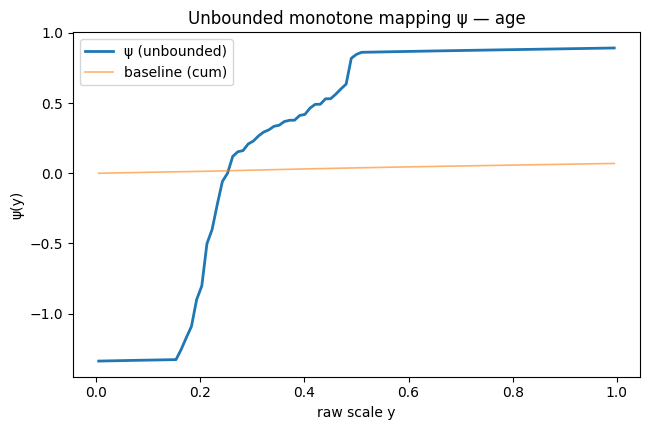

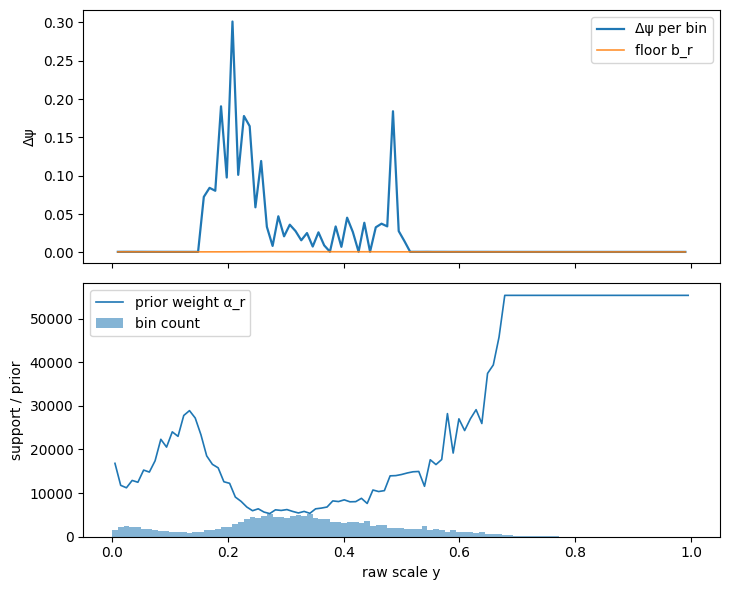

Saved CSVs: scale_learning_age_unbounded/psi_lookup_age_unbounded.csv and scale_learning_age_unbounded/Theta_sigma_age_unbounded.csv


In [96]:
# Unbounded-scale monotone mapping with learned (mu, sigma) around logit
# - Bootstrapped per-item ratings via your loader
# - Heteroscedastic per-item variances
# - Strict per-bin Δψ floor (no flat collapses)
# - Adaptive prior against overconfident tails
# - (mu, sigma) learned via EMA each iteration to make the logit “comfortable”
# - Optional TensorBoard logging

import numpy as np
import pandas as pd
import torch
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Any

# ---------------------------- bootstrap + loader ----------------------------
def bootstrap_tensor(y: torch.Tensor) -> torch.Tensor:
    """
    Vectorized bootstrap with replacement along the last dimension.
    NaNs are ignored; sampling is only from valid entries.
    If a row has <1 valid value, returns NaNs for that row.
    """
    if y.ndim == 1:
        y = y.unsqueeze(0)
    B, R = y.shape
    y_np = y.detach().cpu().numpy()
    out = np.full_like(y_np, np.nan, dtype=np.float32)
    rng = np.random.default_rng(12345)
    for i in range(B):
        row = y_np[i]
        valid_idx = np.where(np.isfinite(row))[0]
        if valid_idx.size == 0:
            continue
        # sample exactly R indices with replacement
        draw = rng.choice(valid_idx, size=R, replace=True)
        out[i] = row[draw]
    return torch.from_numpy(out).to(y.dtype)

def pad_list(l, max_len):
    return l[:max_len] + [np.nan] * (max_len - len(l[:max_len]))

def load_interp_data(base_dir = "/Users/adamsobieszek/PycharmProjects/PsychGAN/", scale=1) -> Tuple[
    Dict[str, torch.Tensor],
    Dict[str, Dict[str, torch.Tensor]]
]:
    """
    Load latent coordinates and ratings, and build bootstrapped rating vectors per item.
    Returns: (photo_to_coords, dim_to_photo_to_ratings)
             where dim_to_photo_to_ratings[dimension][photo] -> 1D torch tensor (bootstrapped ints)
    """
    base_dir = Path(base_dir)
    p2c_path = base_dir / "newer_photo_to_coords.pt"
    d2p2r_path = base_dir / "dim_to_photo_to_ratings2.pkl"
    with open(d2p2r_path, "rb") as f:
        dim_to_photo_to_ratings = pickle.load(f)
    photo_to_coords = torch.load(p2c_path, map_location="cpu")
    photo_to_coords = {k: torch.tensor(v).cpu().flatten()[:512] for k, v in photo_to_coords.items()}

    out = {}
    for dim_name, p2r in dim_to_photo_to_ratings.items():
        # choose an oversample length per dimension (2.5x longest)
        max_len = int(max(len(p2r[kk]) for kk in p2r) * 2.5)
        inner = {}
        for kk, ratings in p2r.items():
            base = torch.tensor(pad_list(ratings, max_len), dtype=torch.float32).reshape(1, -1)
            # Optional global scaling (your code had a small shift when scale!=1)
            base = ((-0.005 if scale != 1 else 0.0) + base) * scale
            boot = bootstrap_tensor(base).reshape(-1)     # 1D vector, ints or floats
            inner[kk] = boot.to(dtype=torch.float32)      # keep as float32 for safety
        out[dim_name] = inner

    return photo_to_coords, out

# ---------------------------- helpers ----------------------------
def diffuse(vec, eps):
    if eps <= 0: return vec
    left = np.zeros_like(vec); right = np.zeros_like(vec)
    left[1:]  = vec[:-1]
    right[:-1]= vec[1:]
    return np.maximum(0.0, (1-2*eps)*vec + eps*(left + right))

def weighted_isotonic(y_vals, w_vals):
    """
    Weighted PAV on an already-ordered 1D grid.
    Returns fitted nondecreasing values (NaNs remain if all weights zero; caller fills).
    """
    mask = w_vals > 0
    y = y_vals[mask]
    w = w_vals[mask]
    if y.size == 0:
        return np.full_like(y_vals, np.nan, dtype=float)

    block_y = y.astype(float).tolist()
    block_w = w.astype(float).tolist()
    block_idx = list(range(len(y)))

    i = 0
    while i < len(block_y) - 1:
        if block_y[i] > block_y[i+1]:
            wy = block_w[i]*block_y[i] + block_w[i+1]*block_y[i+1]
            ww = block_w[i] + block_w[i+1]
            block_y[i] = wy / (ww + 1e-12)
            block_w[i] = ww
            del block_y[i+1]; del block_w[i+1]; del block_idx[i+1]
            if i > 0: i -= 1
        else:
            i += 1

    y_fit_masked = np.empty_like(y)
    for b in range(len(block_y)):
        s = block_idx[b]
        e = block_idx[b+1] if b+1 < len(block_y) else len(y_fit_masked)
        y_fit_masked[s:e] = block_y[b]

    y_fit_full = np.full_like(y_vals, np.nan, dtype=float)
    y_fit_full[mask] = y_fit_masked
    return y_fit_full

def fill_nearest(y_fit, low=None, high=None):
    y = y_fit.copy()
    idx = np.where(~np.isnan(y))[0]
    if idx.size == 0:
        y = np.linspace(0.0, 1.0, len(y))
    else:
        first, last = idx[0], idx[-1]
        for i in range(first-1, -1, -1): y[i] = y[i+1]
        for i in range(last+1, len(y)):  y[i] = y[i-1]
    if low is not None or high is not None:
        low  = -np.inf if low  is None else low
        high =  np.inf if high is None else high
        y = np.clip(y, low, high)
    return y

def logit(p):
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return np.log(p) - np.log(1 - p)

# ---------------------------- Trainer ----------------------------
class MonotoneMappingTrainer:
    def __init__(self, config: Dict[str, Any]):
        self.cfg = config
        self.writer = None
        if self.cfg.get("logging", {}).get("tensorboard", False):
            try:
                from torch.utils.tensorboard import SummaryWriter
                log_dir = self.cfg["logging"].get("log_dir", "./runs/monotone_mapping")
                self.writer = SummaryWriter(log_dir=log_dir)
            except Exception as e:
                print(f"(TensorBoard disabled) {e}")
                self.writer = None

    def _log_scalar(self, name, value, step):
        if self.writer is not None:
            self.writer.add_scalar(name, value, step)

    def fit(self, dim_to_photo_to_ratings: Dict[str, Dict[str, torch.Tensor]], dimension_name_hint="age"):
        # ------------- Pull config -------------
        min_ratings       = self.cfg["data"].get("min_ratings", 10)
        max_iters         = self.cfg["training"].get("max_iters", 200)
        tol               = self.cfg["training"].get("tol", 1e-6)
        sigma_floor       = self.cfg["model"].get("sigma_floor", 1e-4)
        neighbor_diff     = self.cfg["model"].get("neighbor_diffusion", 0.15)
        # Prior
        prior_strength    = self.cfg["model"].get("prior_strength", 3.0)
        prior_power       = self.cfg["model"].get("prior_power", 1.0)
        prior_center      = self.cfg["model"].get("prior_center", "linear_u")  # or "previous"
        # Strict floor
        min_delta_per_bin = self.cfg["model"].get("min_delta_per_bin", 6e-4)
        adaptive_floor_mass = self.cfg["model"].get("adaptive_floor_mass", 0.02)
        baseline_from     = self.cfg["model"].get("baseline_from", "counts")
        # Logit/EMA
        eps               = self.cfg["model"].get("eps", 1.0/202.0)
        ema_rate          = self.cfg["model"].get("ema_rate", 0.25)
        sigma_min_logit   = self.cfg["model"].get("sigma_min_logit", 0.35)

        # ------------- Select dimension & collect data -------------
        dims = list(dim_to_photo_to_ratings.keys())
        dim = next((d for d in dims if dimension_name_hint.lower() in d.lower()), dims[0])
        p2r = dim_to_photo_to_ratings[dim]

        # Filter photos
        def looks_like_target(p):
            try:
                base = Path(p).stem
                n = int(base)
                return 1 <= n <= 1004
            except Exception:
                return False
        photos = sorted([p for p,t in p2r.items() if len(t) >= min_ratings and looks_like_target(p)])
        if not photos:
            photos = sorted([p for p,t in p2r.items() if len(t) >= min_ratings])
        I = len(photos)
        if I == 0:
            raise RuntimeError("No photos with sufficient ratings.")

        photo_idx = {p:i for i,p in enumerate(photos)}
        R_all, idx_i = [], []
        for p in photos:
            # NOTE: these are bootstrapped vectors already (ints/float)
            r = p2r[p].detach().cpu().numpy()
            R_all.append(r)
            idx_i.extend([photo_idx[p]]*len(r))
        R_all = np.concatenate(R_all, axis=0)
        idx_i = np.asarray(idx_i, dtype=np.int32)
        n_i = np.bincount(idx_i, minlength=I).astype(np.int32)

        # rating grid
        grid_r = np.arange(0, 101, dtype=np.int32)
        y_grid = (grid_r + 0.5) / 101.0

        # initialize μ, σ from the raw y distribution
        # clamp away from edges to keep logit sane
        y_all = np.clip((R_all + 0.5) / 101.0, eps, 1 - eps)
        mu = float(y_all.mean())
        sig = float(y_all.std(ddof=0))
        sig = max(sig, sigma_min_logit)

        # Initialize ψ on bins (unbounded scale), start roughly as standardized logit
        u_grid = logit(np.clip(0.5 + (y_grid - mu)/max(sig, 1e-12), eps, 1 - eps))
        u_grid = (u_grid - u_grid.mean()) / (u_grid.std(ddof=0) + 1e-12)
        psi_bins = u_grid.copy()

        Theta = np.zeros(I, dtype=np.float64)
        sigma2 = np.ones(I, dtype=np.float64) * max(sigma_floor**2, 1e-6)

        # Supports per bin (for priors & adaptive floors)
        C_r_raw = np.bincount(R_all.astype(np.int32), minlength=101).astype(np.float64)
        C_r_smooth = diffuse(C_r_raw, neighbor_diff)

        # Per-interval floor b_inc (length 100) and cumulative baseline
        Ninc = 100
        floor_uniform = np.full(Ninc, min_delta_per_bin, dtype=float)
        if adaptive_floor_mass > 0:
            if baseline_from == "counts":
                density = C_r_smooth[:-1] + 1.0
            else:
                density = np.ones(Ninc, dtype=float)
            density = density / (density.sum() + 1e-12)
            floor_adapt = adaptive_floor_mass * density
        else:
            floor_adapt = 0.0
        b_inc = floor_uniform + floor_adapt
        total_floor = float(b_inc.sum())
        if total_floor >= 0.98:  # feasibility
            b_inc *= 0.98 / total_floor
        B_cum = np.concatenate([[0.0], np.cumsum(b_inc)])  # length 101

        prev_obj = None
        for it in range(max_iters):
            # --- current standardized logit grid (depends on μ,σ)
            u_grid = logit(np.clip(0.5 + (y_grid - mu)/max(sig, 1e-12), eps, 1 - eps))
            u_grid_std = (u_grid - u_grid.mean()) / (u_grid.std(ddof=0) + 1e-12)

            # ---- A-step: Θ (item locations on ψ-scale)
            z_all = psi_bins[R_all.astype(np.int32)]
            sum_z = np.bincount(idx_i, weights=z_all, minlength=I).astype(np.float64)
            Theta = sum_z / np.maximum(n_i, 1)
            Theta = (Theta - Theta.mean()) / (Theta.std(ddof=0) + 1e-12)

            # ---- S-step: σ²_i (heteroscedastic per item)
            res = z_all - Theta[idx_i]
            sum_res2 = np.bincount(idx_i, weights=res*res, minlength=I).astype(np.float64)
            sigma2_mle = sum_res2 / np.maximum(n_i, 1)
            sigma2 = np.maximum(sigma2_mle, sigma_floor**2)

            # ---- B-step on φ = ψ - B to enforce Δψ >= b_inc
            w_i = 1.0 / (sigma2 + 1e-12)
            wi_obs = w_i[idx_i]
            # Aggregate to rating bins
            T_r = np.bincount(R_all.astype(np.int32), weights=wi_obs*Theta[idx_i], minlength=101).astype(np.float64)
            W_r = np.bincount(R_all.astype(np.int32), weights=wi_obs,               minlength=101).astype(np.float64)
            # mild diffusion
            T_r = diffuse(T_r, neighbor_diff)
            W_r = diffuse(W_r, neighbor_diff)

            # Prior center for ψ on bins
            if prior_center == "previous":
                prior_mu_psi = psi_bins.copy()
            else:  # "linear_u": shrink toward standardized u_grid
                prior_mu_psi = u_grid_std.copy()

            # Convert to φ prior: μ_φ = μ_ψ - B
            prior_mu_phi = prior_mu_psi - B_cum

            # Prior weights α_r: stronger when support is low
            C_med = np.median(C_r_raw[C_r_raw > 0]) if np.any(C_r_raw > 0) else 1.0
            W_nonzero = W_r[W_r > 0]
            W_med = np.median(W_nonzero) if W_nonzero.size > 0 else 1.0
            alpha_r = prior_strength * W_med * (C_med / (C_r_raw + 1.0))**prior_power
            alpha_r = np.clip(alpha_r, 0.0, 10.0 * W_med)

            # Targets for φ: (m_r - B) with prior
            m_r_phi_num = T_r - W_r * B_cum + alpha_r * prior_mu_phi
            W_r_phi      = W_r + alpha_r
            with np.errstate(divide='ignore', invalid='ignore'):
                m_r_phi = m_r_phi_num / np.maximum(W_r_phi, 1e-12)

            # Weighted isotonic for φ (nondecreasing)
            phi_fit = weighted_isotonic(m_r_phi, W_r_phi)
            phi_fit = fill_nearest(phi_fit)
            phi_fit = np.maximum.accumulate(phi_fit)

            # Recover ψ and guarantee Δψ >= b_inc
            psi_bins = B_cum + phi_fit

            # ---- objective (profile likelihood + prior penalty on φ)
            z_all = psi_bins[R_all.astype(np.int32)]
            res = z_all - Theta[idx_i]
            sum_res2 = np.bincount(idx_i, weights=res*res, minlength=I).astype(np.float64)
            sigma2 = np.maximum(sum_res2 / np.maximum(n_i, 1), sigma_floor**2)
            like = 0.5 * np.sum((sum_res2 / np.maximum(sigma2, 1e-12)) + n_i * np.log(np.maximum(sigma2, 1e-12)))
            prior_pen = 0.5 * np.sum(alpha_r * ((psi_bins - B_cum) - prior_mu_phi)**2)
            obj = like + prior_pen

            # ---- EMA update for (mu, sig) based on weighted y distribution
            W_tot = np.sum(W_r)
            if W_tot > 0:
                mu_hat = float(np.sum(W_r * y_grid) / W_tot)
                var_hat = float(np.sum(W_r * (y_grid - mu_hat)**2) / W_tot)
                sig_hat = float(np.sqrt(max(var_hat, 1e-12)))
            else:
                mu_hat, sig_hat = mu, sig
            mu_prev, sig_prev = mu, sig
            mu = (1 - ema_rate) * mu + ema_rate * mu_hat
            sig = (1 - ema_rate) * sig + ema_rate * max(sig_hat, sigma_min_logit)

            # ---- logging
            dpsi = np.diff(psi_bins)
            self._log_scalar("loss/obj", obj, it)
            self._log_scalar("loss/like", like, it)
            self._log_scalar("loss/prior_pen", prior_pen, it)
            self._log_scalar("geom/min_delta", dpsi.min(), it)
            self._log_scalar("scale/mu", mu, it)
            self._log_scalar("scale/sigma", sig, it)

            # convergence
            if prev_obj is not None and abs(prev_obj - obj) / (abs(prev_obj) + 1e-12) < tol:
                break
            prev_obj = obj

        # ---- outputs ----
        dpsi = np.diff(psi_bins)
        psi_table = pd.DataFrame({
            "rating_int": grid_r,
            "y_unit": y_grid,
            "psi": psi_bins,
            "bin_count": C_r_raw,
            "alpha_prior": alpha_r,
            "baseline_cum": B_cum
        })
        baseline_inc = b_inc.copy()  # length 100

        Theta_df = pd.DataFrame({
            "photo": photos,
            "Theta": Theta,
            "sigma": np.sqrt(sigma2),
            "n": n_i
        })

        diagnostics = dict(
            iterations = it+1,
            obj = float(obj),
            mu = float(mu),
            sigma = float(sig),
            min_delta = float(dpsi.min()),
            floor_min = float(b_inc.min()),
            violates_floor = bool((dpsi < b_inc - 1e-12).any()),
            dimension = dim
        )

        return dict(
            dimension=dim,
            psi_table=psi_table,
            Theta=Theta_df,
            diagnostics=diagnostics,
            baseline_inc=baseline_inc
        )

# ---------------------------- Config ----------------------------
CONFIG = {
    "data": {
        "min_ratings": 10,
        "base_dir": "/Users/adamsobieszek/PycharmProjects/PsychGAN/",
        "bootstrap_scale": 101.0,
    },
    "training": {
        "max_iters": 2000,
        "tol": 1e-6,
    },
    "model": {
        "sigma_floor": 1e-7,
        "neighbor_diffusion": 0.01,
        "prior_strength": 3.0,
        "prior_power": 1.0,
        "prior_center": "linear_u",   # or "previous"
        "min_delta_per_bin": 6e-4,
        "adaptive_floor_mass": 0.01,
        "baseline_from": "counts",
        "eps": 1.0/202.0,
        "ema_rate": 0.2,
        "sigma_min_logit": 0.25,
    },
    "logging": {
        "tensorboard": True,
        "log_dir": "./runs/monotone_mapping_unbounded"
    }
}

# ---------------------------- Run ----------------------------
# Load bootstrapped data using your loader
photo_to_coords, dim_to_photo_to_ratings = load_interp_data(CONFIG["data"]["base_dir"], scale=CONFIG["data"]["bootstrap_scale"])

# Train
trainer = MonotoneMappingTrainer(CONFIG)
results = trainer.fit(dim_to_photo_to_ratings, dimension_name_hint="age")

psi_table = results["psi_table"]
Theta_df  = results["Theta"]
diagn     = results["diagnostics"]
b_inc     = results["baseline_inc"]
dim_name  = results["dimension"]

print("Diagnostics:", diagn)

# ---------------------------- Visualize ----------------------------
x = psi_table["y_unit"].values
y = psi_table["psi"].values
B = psi_table["baseline_cum"].values
dpsi = np.diff(y)
mid  = (x[:-1] + x[1:]) / 2.0

fig, ax = plt.subplots(1,1, figsize=(6.6,4.4))
ax.plot(x, y, lw=2, label="ψ (unbounded)")
ax.plot(x, B, lw=1.2, alpha=0.6, label="baseline (cum)")
ax.set_xlabel("raw scale y"); ax.set_ylabel("ψ(y)")
ax.set_title(f"Unbounded monotone mapping ψ — {dim_name}")
ax.legend(); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(2,1, figsize=(7.4,6.0), sharex=True)
ax[0].plot(mid, dpsi, lw=1.6, label="Δψ per bin")
ax[0].plot(mid, b_inc, lw=1.2, alpha=0.85, label="floor b_r")
ax[0].set_ylabel("Δψ"); ax[0].legend()
ax[1].bar(x, psi_table["bin_count"].values, width=1/101, alpha=0.55, label="bin count")
ax[1].plot(x, psi_table["alpha_prior"].values, lw=1.2, label="prior weight α_r")
ax[1].set_xlabel("raw scale y"); ax[1].set_ylabel("support / prior"); ax[1].legend()
plt.tight_layout(); plt.show()

# Save artifacts
out_dir = Path("./scale_learning_age_unbounded")
out_dir.mkdir(parents=True, exist_ok=True)
psi_csv   = out_dir / f"psi_lookup_{dim_name}_unbounded.csv"
theta_csv = out_dir / f"Theta_sigma_{dim_name}_unbounded.csv"
psi_table.to_csv(psi_csv, index=False)
Theta_df.to_csv(theta_csv, index=False)
print("Saved CSVs:", psi_csv, "and", theta_csv)

In [97]:
# ------------------ Live Visualizer (Plotly, async) v2 ------------------
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor
from queue import Queue, Empty, Full
import numpy as np
import torch

class LiveInverseMappingVisualizer:
    """
    Column 1 (spans rows): mapping ψ(y) vs best linear baseline.
    Column 2 (rows 1..3): three example items stacked, hist of z=ψ(y) and current N(Θ,σ²) pdf.
    Column 3 (spans rows): scatter of Beta(α,β) fitted on re-scaled transformed ratings
                           z -> y_tilde in [0.005, 0.995] via global min/max.
    """
    def __init__(self, dataset, example_item_ids=None, grid_points=401, hist_bins=30,
                 beta_clip=(0.005, 0.995), kappa_min=1e-3):
        self.ds = dataset
        self.grid_points = int(grid_points)
        self.hist_bins = int(hist_bins)
        self.beta_clip = beta_clip
        self.kappa_min = float(kappa_min)

        # Choose 3 examples: low/median/high mean on raw unit scale
        if example_item_ids is None:
            means = []
            for r in self.ds.ratings:
                if r.max()< 2: r = (r-0.005)*101
                y_int = r.clone().float()
                y = torch.where(torch.isnan(y_int), y_int,
                                torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6))
                y = y[~torch.isnan(y)]
                means.append(0.5 if y.numel()==0 else float(y.mean()))
            order = np.argsort(means)
            lo = int(order[max(0, int(0.1 * len(order)) - 1)])
            md = int(order[int(0.5 * len(order))])
            hi = int(order[min(len(order)-1, int(0.9 * len(order)))])
            example_item_ids = [lo, md, hi]
        self.example_item_ids = example_item_ids

        # Figure: rows=3, cols=3; col1 spans all rows; col3 spans all rows; col2 has 3 stacked plots
        specs = [
            [{"type":"xy", "rowspan":3}, {"type":"xy"}, {"type":"xy", "rowspan":3}],
            [None,                    {"type":"xy"}, None],
            [None,                    {"type":"xy"}, None],
        ]
        titles = (
            "Mapping ψ(y) (red) & Best Linear Baseline (gray)",
            f"Example #{self.example_item_ids[0]}",
            f"Example #{self.example_item_ids[1]}",
            f"Example #{self.example_item_ids[2]}",
            "Beta(α, β) over items",
        )
        self.fig = go.FigureWidget(make_subplots(
            rows=3, cols=3, specs=specs, column_widths=[0.55, 0.25, 0.20],
            subplot_titles=(titles[0], titles[1], titles[2], titles[3], titles[4])
        ))

        # Column 1 (row 1 span): baseline + ψ
        self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="gray", width=2, dash="dash"),
                                      name="baseline", showlegend=False), row=1, col=1)
        self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="red", width=3),
                                      name="psi", showlegend=False), row=1, col=1)

        # Column 2: three example panels (each bar + pdf)
        colors = ["#729ECE", "#8EBA42", "#FF9DA7"]
        for r in (1,2,3):
            cidx = r-1
            self.fig.add_trace(go.Bar(name=f"hist{r}", marker=dict(color=colors[cidx], opacity=0.45),
                                      showlegend=False), row=r, col=2)
            self.fig.add_trace(go.Scatter(mode="lines", line=dict(color=colors[cidx], width=2),
                                          name=f"pdf{r}", showlegend=False), row=r, col=2)

        # Column 3 (row 1 span): alpha-beta scatter
        self.fig.add_trace(go.Scatter(mode="markers",
                                      marker=dict(size=6, color="#444", opacity=0.6),
                                      name="Beta αβ", showlegend=False), row=1, col=3)

        # Axes labels
        self.fig.update_xaxes(title_text="y (slider in [0,1])", row=1, col=1)
        self.fig.update_yaxes(title_text="ψ(y)", row=1, col=1)
        for r in (1,2,3):
            self.fig.update_xaxes(title_text="z = ψ(y)", row=r, col=2)
            self.fig.update_yaxes(title_text="density", row=r, col=2)
        self.fig.update_xaxes(title_text="α (Beta)", row=1, col=3)
        self.fig.update_yaxes(title_text="β (Beta)", row=1, col=3)

        self.fig.update_layout(width=1800, height=760, title_text="Live Inverse Mapping Training",
                               margin=dict(l=50,r=20,t=60,b=40))

        display(self.fig)

        # Async infra
        self.executor = ThreadPoolExecutor(max_workers=1)
        self.plot_data_queue = Queue(maxsize=1)

        # Cache all items' unit ratings (list of np arrays)
        self._all_unit_ratings = []
        for r in self.ds.ratings:
            y_int = r.clone().float()
            y = torch.where(torch.isnan(y_int), y_int,
                            torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6))
            y = y[~torch.isnan(y)]
            self._all_unit_ratings.append(y.cpu().numpy())
        # Cache 3 examples
        self._cached_unit_examples = {iid: self._all_unit_ratings[iid] for iid in self.example_item_ids}

    @torch.no_grad()
    def _prepare_and_queue_data(self, psi_model, emb_module):
        device = next(psi_model.parameters()).device

        # --- Mapping curve ---
        ygrid = torch.linspace(1e-6, 1-1e-6, self.grid_points, device=device)
        zgrid_t = psi_model(ygrid)
        zgrid = zgrid_t.detach().cpu().numpy()
        y_np = ygrid.detach().cpu().numpy()
        # Best linear baseline a + b*y
        X = np.stack([np.ones_like(y_np), y_np], axis=1)
        a_b, *_ = np.linalg.lstsq(X, zgrid, rcond=None)
        z_lin = X @ a_b

        # --- Three example items (z hist + current Gaussian pdf) ---
        hist_data = []
        for iid in self.example_item_ids:
            y_unit = self._cached_unit_examples[iid]
            if y_unit.size == 0:
                hist_data.append({"x": np.array([]), "h": np.array([]), "pdf_x": np.array([]), "pdf_y": np.array([])})
                continue
            yt = torch.tensor(y_unit, device=device, dtype=torch.float32)
            z = psi_model(yt).detach().cpu().numpy()
            zmin, zmax = np.quantile(z, [0.01, 0.99]) if z.size>1 else (float(z.min()), float(z.max()+1e-6))
            edges = np.linspace(zmin, zmax, self.hist_bins+1)
            centers = 0.5*(edges[:-1] + edges[1:])
            counts, _ = np.histogram(z, bins=edges, density=True)

            theta_i, sigma_i = emb_module(torch.tensor([iid], device=device))
            mu = float(theta_i.squeeze().detach().cpu().numpy())
            sd = float(sigma_i.squeeze().detach().cpu().numpy())
            pdf_x = np.linspace(zmin, zmax, 200)
            pdf_y = (1.0/(np.sqrt(2*np.pi)*sd)) * np.exp(-(pdf_x-mu)**2/(2*sd**2))

            hist_data.append({"x": centers, "h": counts, "pdf_x": pdf_x, "pdf_y": pdf_y})

        # --- Alpha-Beta scatter from Beta fits on re-scaled transformed ratings ---
        # 1) compute global z_min/z_max across all items
        z_global_min = np.inf
        z_global_max = -np.inf
        for arr in self._all_unit_ratings:
            if arr.size == 0: continue
            yt = torch.tensor(arr, device=device, dtype=torch.float32)
            z  = psi_model(yt).detach().cpu().numpy()
            if z.size == 0: continue
            z_global_min = min(z_global_min, float(np.min(z)))
            z_global_max = max(z_global_max, float(np.max(z)))
        if not np.isfinite(z_global_min) or not np.isfinite(z_global_max) or z_global_max <= z_global_min:
            z_global_min, z_global_max = -1.0, 1.0  # safe default

        lo, hi = self.beta_clip
        alpha_list, beta_list = [], []
        for arr in self._all_unit_ratings:
            if arr.size < 2:
                alpha_list.append(np.nan); beta_list.append(np.nan); continue
            yt = torch.tensor(arr, device=device, dtype=torch.float32)
            z  = psi_model(yt).detach().cpu().numpy()
            if z.size < 2:
                alpha_list.append(np.nan); beta_list.append(np.nan); continue
            # affine map to [lo,hi]
            ztil = (z - z_global_min) / max(1e-12, (z_global_max - z_global_min))
            ytil = np.clip(lo + (hi - lo) * ztil, lo, hi)
            m = float(np.mean(ytil))
            v = float(np.var(ytil, ddof=1)) if ytil.size>1 else 1e-6
            m = np.clip(m, lo, hi)
            v = max(v, 1e-8)
            denom = m*(1-m)
            if denom <= 1e-8:
                kappa = 1e6
            else:
                kappa = max(self.kappa_min, denom / v - 1.0)
            alpha = m * kappa
            beta  = (1.0 - m) * kappa
            alpha_list.append(alpha)
            beta_list.append(beta)

        alpha_arr = np.array(alpha_list, dtype=np.float64)
        beta_arr  = np.array(beta_list,  dtype=np.float64)
        valid = np.isfinite(alpha_arr) & np.isfinite(beta_arr) & (alpha_arr>0) & (beta_arr>0)
        alpha_arr = alpha_arr[valid]
        beta_arr  = beta_arr[valid]

        # Push latest frame
        payload = (y_np, zgrid, z_lin, hist_data, alpha_arr, beta_arr)
        try:
            self.plot_data_queue.get_nowait()
        except Empty:
            pass
        try:
            self.plot_data_queue.put_nowait(payload)
        except Full:
            pass

    def update_async(self, psi_model, emb_module):
        self.executor.submit(self._prepare_and_queue_data, psi_model, emb_module)

    def check_and_update_plot(self):
        try:
            y_np, zgrid, z_lin, hist_data, alpha_arr, beta_arr = self.plot_data_queue.get_nowait()
        except Empty:
            return
        with self.fig.batch_update():
            # Column 1 (mapping: traces 0,1)
            self.fig.data[0].x = y_np
            self.fig.data[0].y = z_lin
            self.fig.data[1].x = y_np
            self.fig.data[1].y = zgrid

            # Column 2 (examples): traces 2..7 (bar,pdf)x3
            for r in range(3):
                base = 2 + 2*r
                h = hist_data[r]
                self.fig.data[base + 0].x = h["x"]
                self.fig.data[base + 0].y = h["h"]
                self.fig.data[base + 1].x = h["pdf_x"]
                self.fig.data[base + 1].y = h["pdf_y"]

            # Column 3 (scatter): trace 8
            self.fig.data[8].x = alpha_arr
            self.fig.data[8].y = beta_arr


In [98]:
# --- NEW: compute item location statistic over [0,1] ---
def compute_item_locations_unit(dataset, stat="mean"):
    ms = []
    for r in dataset.ratings:
        y_int = r.clone().float()
        y = torch.where(torch.isnan(y_int), y_int, torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6))
        y = y[~torch.isnan(y)]
        if y.numel() == 0:
            ms.append(0.5)
        else:
            ms.append(float(y.mean() if stat == "mean" else y.median()))
    return np.array(ms, dtype=np.float64)

# --- NEW: simple, stable density-reweighting over m in [0,1] via histogram ---
def make_density_weights_from_m(ms, bins=20, target="uniform",
                                clip_min=0.33, clip_max=3.0, gamma=0.75, eps=1e-6) -> torch.Tensor:
    ms = np.clip(ms, 1e-6, 1-1e-6)
    hist, edges = np.histogram(ms, bins=bins, range=(0,1), density=False)
    N = ms.shape[0]
    binwidth = (edges[1] - edges[0])
    # empirical density per unit x
    dens = (hist + eps) / (N * binwidth + eps * bins)
    # map each m to its bin density
    idx = np.minimum(bins-1, (ms * bins).astype(int))
    p_emp = dens[idx]
    # target density: uniform on [0,1] => 1.0 per unit x
    if target == "uniform":
        p_tgt = np.ones_like(p_emp)
    else:
        # placeholder for custom target; default to uniform
        p_tgt = np.ones_like(p_emp)

    w = p_tgt / (p_emp + eps)
    w = np.clip(w, clip_min, clip_max) ** gamma
    w = w / w.mean()  # normalize to mean 1
    return torch.tensor(w, dtype=DTYPE)


In [99]:
# ============================== FIXES ==============================
# 1) SIMPLIFIED VISUALIZER — it no longer computes anything itself.
#    You pass it a ready-made payload from the trainer:
#    {
#      "ygrid": (G,), "zgrid": (G,), "zlin": (G,),
#      "examples": [
#         { "hist_x":(...), "hist_h":(...), "pdf_x":(...), "pdf_y":(...),
#           "tau":(K,), "z_obs":(K,), "z_tgt":(K,), "y_obs":(K,), "y_tgt":(K,) },
#         ... (3 items total)
#      ]
#    }
# ------------------------------------------------------------------

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor
from queue import Queue, Empty, Full
import numpy as np

class LiveInverseMappingVisualizer:
    def __init__(self, example_item_ids, grid_points=401, hist_bins=30, taus=None):
        self.example_item_ids = list(example_item_ids)
        self.grid_points = int(grid_points)
        self.hist_bins = int(hist_bins)
        self.taus = np.asarray(taus if taus is not None else np.linspace(0.01,0.99,99), dtype=float)

        # Layout: col1 mapping; col2 3x (hist+pdf); col3 3x (CDF z); col4 3x (CDF y)
        specs = [
            [{"type":"xy", "rowspan":3}, {"type":"xy"}, {"type":"xy"}, {"type":"xy"}],
            [None,                         {"type":"xy"}, {"type":"xy"}, {"type":"xy"}],
            [None,                         {"type":"xy"}, {"type":"xy"}, {"type":"xy"}],
        ]
        titles = (
            "Mapping ψ(y) (red) & Best Linear Baseline (gray)",
            f"Example #{self.example_item_ids[0]}: z-hist & N(μ,σ²)",
            f"Example #{self.example_item_ids[1]}: z-hist & N(μ,σ²)",
            f"Example #{self.example_item_ids[2]}: z-hist & N(μ,σ²)",
            f"Example #{self.example_item_ids[0]}: CDF in z (obs vs tgt)",
            f"Example #{self.example_item_ids[1]}: CDF in z (obs vs tgt)",
            f"Example #{self.example_item_ids[2]}: CDF in z (obs vs tgt)",
            f"Example #{self.example_item_ids[0]}: CDF in y (obs vs tgt)",
            f"Example #{self.example_item_ids[1]}: CDF in y (obs vs tgt)",
            f"Example #{self.example_item_ids[2]}: CDF in y (obs vs tgt)",
        )
        self.fig = go.FigureWidget(make_subplots(
            rows=3, cols=4, specs=specs, column_widths=[0.40, 0.20, 0.20, 0.20],
            subplot_titles=titles
        ))

        # Column 1: baseline + ψ
        self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="gray", width=2, dash="dash"),
                                      name="baseline", showlegend=False), row=1, col=1)  # trace 0
        self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="red", width=3),
                                      name="psi", showlegend=False), row=1, col=1)       # trace 1

        # Column 2: three example panels (bar + pdf)
        colors = ["#729ECE", "#8EBA42", "#FF9DA7"]
        for r in (1,2,3):
            cidx = r-1
            self.fig.add_trace(go.Bar(name=f"hist{r}", marker=dict(color=colors[cidx], opacity=0.45),
                                      showlegend=False), row=r, col=2)                   # traces 2,4,6
            self.fig.add_trace(go.Scatter(mode="lines", line=dict(color=colors[cidx], width=2),
                                      name=f"pdf{r}", showlegend=False), row=r, col=2)    # traces 3,5,7

        # Column 3: CDF in z (obs vs tgt) per row
        for r in (1,2,3):
            self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="#333", width=2),
                                          name=f"z CDF obs {r}", showlegend=False), row=r, col=3)  # 8,10,12
            self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="#FF5733", width=2, dash="dash"),
                                          name=f"z CDF tgt {r}", showlegend=False), row=r, col=3)  # 9,11,13

        # Column 4: CDF in y (obs vs tgt) per row
        for r in (1,2,3):
            self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="#333", width=2),
                                          name=f"y CDF obs {r}", showlegend=False), row=r, col=4)  # 14,16,18
            self.fig.add_trace(go.Scatter(mode="lines", line=dict(color="#1f77b4", width=2, dash="dash"),
                                          name=f"y CDF tgt {r}", showlegend=False), row=r, col=4)  # 15,17,19

        # Axis labels
        self.fig.update_xaxes(title_text="y (slider in [0,1])", row=1, col=1)
        self.fig.update_yaxes(title_text="ψ(y)", row=1, col=1)
        for r in (1,2,3):
            self.fig.update_xaxes(title_text="z = ψ(y)", row=r, col=2)
            self.fig.update_yaxes(title_text="density", row=r, col=2)
            self.fig.update_xaxes(title_text="z", row=r, col=3)
            self.fig.update_yaxes(title_text="τ", row=r, col=3)
            self.fig.update_xaxes(title_text="y", row=r, col=4)
            self.fig.update_yaxes(title_text="τ", row=r, col=4)

        self.fig.update_layout(width=2000, height=820, title_text="Live OT Training (Observed vs Target CDFs)",
                               margin=dict(l=50,r=20,t=60,b=40))
        display(self.fig)

        # Async queue (payloads are precomputed by trainer)
        self.executor = ThreadPoolExecutor(max_workers=1)
        self.plot_data_queue = Queue(maxsize=1)

    # Trainer calls this with a ready-made payload (dict described above).
    def update_async(self, payload: dict):
        def _push():
            try:
                self.plot_data_queue.get_nowait()
            except Empty:
                pass
            try:
                self.plot_data_queue.put_nowait(payload)
            except Full:
                pass
        self.executor.submit(_push)

    def check_and_update_plot(self):
        try:
            payload = self.plot_data_queue.get_nowait()
        except Empty:
            return

        y_np   = payload["ygrid"]
        zgrid  = payload["zgrid"]
        z_lin  = payload["zlin"]
        exs    = payload["examples"]  # list of 3 dicts

        with self.fig.batch_update():
            # Column 1
            self.fig.data[0].x = y_np;  self.fig.data[0].y = z_lin
            self.fig.data[1].x = y_np;  self.fig.data[1].y = zgrid

            # Column 2: bars + pdfs per example
            for r in range(3):
                base = 2 + 2*r
                self.fig.data[base + 0].x = exs[r]["hist_x"]
                self.fig.data[base + 0].y = exs[r]["hist_h"]
                self.fig.data[base + 1].x = exs[r]["pdf_x"]
                self.fig.data[base + 1].y = exs[r]["pdf_y"]

            # Column 3: z-CDFs (obs, tgt)
            for r in range(3):
                base = 8 + 2*r
                self.fig.data[base + 0].x = exs[r]["z_obs"]
                self.fig.data[base + 0].y = exs[r]["tau"]
                self.fig.data[base + 1].x = exs[r]["z_tgt"]
                self.fig.data[base + 1].y = exs[r]["tau"]

            # Column 4: y-CDFs (obs, tgt)
            for r in range(3):
                base = 14 + 2*r
                self.fig.data[base + 0].x = exs[r]["y_obs"]
                self.fig.data[base + 0].y = exs[r]["tau"]
                self.fig.data[base + 1].x = exs[r]["y_tgt"]
                self.fig.data[base + 1].y = exs[r]["tau"]

# ==================== TRAINER-SIDE CHANGES ====================
# 2) FIX the OT target call (clean single-line invocation)
#    and build a payload for the visualizer so it doesn't duplicate logic.

# --- inside your trainer class OTMonotoneTrainerKAN ---


In [125]:
# ============================================================
# OT training with batched items for a global monotone ψ:(0,1)->R
# ψ is implemented with a Kolmogorov–Arnold Network (KAN) whose
# derivative is positive and integrated to get a monotone map.
#
# Targets per batch:
#   z_hat = ψ(Q_y(τ))
#   mirror z around median (paired τ and 1-τ) → z_sym
#   y_sym = ψ^{-1}(z_sym)
#   y_snap = round(100*y_sym)/100 ∈ {0, 0.01, ..., 0.99}; cummax across τ
#   z_tgt = ψ(y_snap) [stop-grad]
#   OT loss = MSE(z_hat, z_tgt) + λ * curvature(ψ)
#
# - ≥ 51 quantiles (default 99: 0.01..0.99)
# - Train/val DataLoaders
# - Ranger optimizer (fallback to AdamW)
# - Live visualizer; emb_module.forward(item_ids) -> (mu, sd)
# ============================================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

# ---------- Config ----------
CONFIG = {
    "data": {
        "base_dir": "/Users/adamsobieszek/PycharmProjects/PsychGAN/",
        "target_dim": "age",
        "min_ratings": 10,
        "val_split": 0.1,
        "quantiles_count": 101,     # >= 51; includes 0.5
        "train_jitter": False,      # reduce heaping in training
        "val_jitter": False
    },
    "model": {
        "grid_M": 200,             # grid for integration/interp
        "eps_floor": 0,         # derivative floor inside softplus()
        "smooth_lambda": 1e-8,     # small curvature penalty
        # KAN multi-resolution layers
        "kan": [
            {"num_grids": 12, "order": 3},
            {"num_grids": 24, "order": 3},
            {"num_grids": 48, "order": 3}
        ]
    },
    "training": {
        "epochs": 400,
        "batch_size": 64,
        "optimizer": {
            "type": "adamw",      # {"ranger", "adamw"}
            "lr": 8e-4,
            "weight_decay": 0
        },
        "print_every": 1,
        "viz_every": 1,
        "grad_clip_norm": 5.0
    }
}

# ---------- Device / dtype ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DTYPE  = torch.float32
torch.set_default_dtype(DTYPE)

# ---------- Assume these exist in the session ----------
# - load_interp_data(base_dir, scale)
# - LiveInverseMappingVisualizer

# ---------- Data utilities ----------
def to_unit(y_int: torch.Tensor) -> torch.Tensor:
    # (r + 0.5)/101 in (0,1); keep NaNs
    return torch.where(
        torch.isnan(y_int),
        y_int,
        torch.clamp((y_int + 0.5)/101.0, 1e-6, 1-1e-6)
    )

def load_and_stack(base_dir:str, target_dim:str="age", min_ratings:int=10):
    """
    Uses load_interp_data and stacks bootstrapped, padded rating vectors
    into [I, L] raw integer ratings with NaNs.
    """
    _, dim_to_photo_to_ratings = load_interp_data(base_dir=base_dir, scale=1)
    dim_to_photo_to_ratings = {k:{kk:vv for kk,vv in v.items() if torch.mean(vv) > .10} for k,v in dim_to_photo_to_ratings.items()}
    dims = list(dim_to_photo_to_ratings.keys())
    dim = next((d for d in dims if target_dim.lower() in d.lower()), dims[0])

    p2r = dim_to_photo_to_ratings[dim]

    rows, keys = [], []
    for k, r in p2r.items():
        r = torch.as_tensor(r, dtype=DTYPE)-0.005
        r = r*1.01
        n_valid = (~torch.isnan(r)).sum().item()
        if n_valid >= min_ratings:
            rows.append(r)
            keys.append(k)
    if not rows:
        raise RuntimeError("No items with enough ratings.")
    R = torch.stack(rows, dim=0)  # [I, L]
    return R, keys

def build_unit_with_jitter(R_raw: torch.Tensor, enable_jitter: bool) -> torch.Tensor:
    """
    Convert to unit (r+0.5)/101 and optionally add ±(0.5/101) uniform jitter (no generator).
    """
    y = to_unit(R_raw)
    if enable_jitter:
        jitter_amp = 0.5/101.0
        noise = (torch.rand_like(y) - 0.5) * (2*jitter_amp)
        y = torch.where(torch.isnan(y), y, torch.clamp(y + noise, 1e-6, 1-1e-6))
    return y

def nanquantile_rows(y_unit: torch.Tensor, taus: np.ndarray) -> torch.Tensor:
    """
    Per-row quantiles ignoring NaNs. Returns [N, K] tensor (float32) on CPU.
    """
    y_np = y_unit.detach().cpu().numpy()
    Q = np.nanquantile(y_np, q=np.array(taus, dtype=np.float64), axis=1, method="linear")
    return torch.tensor(Q.T, dtype=DTYPE)

# ---------- Dataset & Collate ----------
class ItemsDataset(Dataset):
    """
    Dataset of items (faces). Exposes raw and unit+jitter ratings matrices.
    """
    def __init__(self, R_raw: torch.Tensor, enable_jitter: bool):
        self.R_raw = R_raw              # [I, L], raw integers with NaNs (CPU tensor is fine)
        self.Y_unit = build_unit_with_jitter(R_raw, enable_jitter)
        self.I = self.R_raw.shape[0]
    def __len__(self): return self.I
    def __getitem__(self, idx): return int(idx)

def collate_quantiles_factory(taus: np.ndarray, dataref):
    """
    FIX: ItemsDataset.__getitem__ returns BASE indices. For Subset, the batch
    already contains base indices (Subset forwards base_idx to dataset.__getitem__),
    so DO NOT remap via ref.indices; just index the base directly.
    """
    taus = np.asarray(taus, dtype=np.float64)
    def _collate(batch_idx_list):
        # batch_idx_list are base item ids (both for Dataset and Subset here)
        item_ids = torch.as_tensor(batch_idx_list, dtype=torch.long)
        base = dataref.dataset if isinstance(dataref, Subset) else dataref
        y_batch = base.Y_unit.index_select(0, item_ids)                 # [B, L]
        Q = nanquantile_rows(y_batch, taus).to(DEVICE)                  # [B, K]
        return {"item_ids": item_ids.to(DEVICE), "Qy": Q}
    return _collate

def build_targets_from_mu_sd(
    psi_model: nn.Module,
    item_ids: torch.Tensor,          # (B,) base indices (as returned by your collate)
    base_dataset,                    # ItemsDataset (must expose .Y_unit: [I,L] with NaNs)
    taus: np.ndarray,                # e.g., np.linspace(0.01, 0.99, 99)
    eps_sd: float = 1e-8
) -> torch.Tensor:
    """
    Construct OT targets in *z*-space using the *current* mean and std of the
    transformed ratings for each item:

        z_tgt_i(τ) = μ_i + σ_i * Φ^{-1}(τ),

    where μ_i, σ_i are computed from { z_ij = ψ(y_ij) } using the actual (jittered)
    ratings stored in `base_dataset.Y_unit`. All operations are batched.

    Returns:
        Z_tgt: (B, K) tensor on the same device as `psi_model`, `detach()`-ed.
    """
    device = next(psi_model.parameters()).device
    taus_t = torch.tensor(taus, dtype=torch.float32, device=device).clamp_(1e-6, 1-1e-6)  # (K,)
    qnorm  = torch.distributions.Normal(0.0, 1.0).icdf(taus_t)                             # (K,)

    # 1) Gather all unit ratings for the batch (with NaNs)  -> (B, L)
    Y = base_dataset.Y_unit.index_select(0, item_ids.to(base_dataset.Y_unit.device)).to(device)

    # 2) Mask valid entries and transform through ψ
    mask = ~torch.isnan(Y)                               # (B, L)
    if mask.sum() == 0:
        # degenerate safety: no data; return zeros
        B, K = item_ids.numel(), taus_t.numel()
        return torch.zeros(B, K, device=device)

    flat_idx = torch.nonzero(mask, as_tuple=False)       # (N_valid, 2) -> [row, col]
    rows = flat_idx[:, 0]
    y_valid = Y[rows, flat_idx[:, 1]]                    # (N_valid,)
    z_valid = psi_model(y_valid)                         # (N_valid,)

    # 3) Compute per-item μ and σ in z-space (batch-reduced, unbiased σ)
    B = Y.size(0)
    ones = torch.ones_like(z_valid)

    sum_z  = torch.zeros(B, device=device).index_add_(0, rows, z_valid)
    sum_z2 = torch.zeros(B, device=device).index_add_(0, rows, z_valid * z_valid)
    n      = torch.zeros(B, device=device).index_add_(0, rows, ones)

    mu = sum_z / torch.clamp(n, min=1.0)

    # population variance; turn into unbiased if n>1
    var = torch.clamp(sum_z2 / torch.clamp(n, min=1.0) - mu * mu, min=1e-8)
    var = var*0.95+ (0.5)*0.05
    unbiased = torch.where(n > 1, var * (n / (n - 1.0)), var)
    sd = torch.sqrt(unbiased + eps_sd)

    # 4) Form Normal targets per item and τ
    Z_tgt = mu.unsqueeze(1) + sd.unsqueeze(1) * qnorm.unsqueeze(0)   # (B, K)
    return Z_tgt.detach()
# ============================================================
# KAN Components
# ============================================================

# --- B-Spline Utility (Provided) ---
def b_spline_basis(x, knots, order):
    """Calculates B-spline basis values recursively."""
    if order == 0:
        return ((x >= knots[:-1]) & (x < knots[1:])).float()

    term1_num = x - knots[:-(order + 1)]
    term1_den = knots[order:-1] - knots[:-(order + 1)]

    term2_num = knots[order + 1:] - x
    term2_den = knots[order + 1:] - knots[1:-order]

    term1_den = torch.clamp(term1_den, min=1e-8)
    term2_den = torch.clamp(term2_den, min=1e-8)

    term1 = (term1_num / term1_den) * b_spline_basis(x, knots, order - 1)[:, :-1]
    term2 = (term2_num / term2_den) * b_spline_basis(x, knots, order - 1)[:, 1:]

    return term1 + term2

# --- Pure KANLayer ---
class KANLayer(nn.Module):
    """
    Kolmogorov-Arnold Network spline layer.
    """
    def __init__(self, grid_min, grid_max, num_grids, spline_order):
        super().__init__()
        h = (grid_max - grid_min) / num_grids
        knots = torch.linspace(
            grid_min - spline_order * h,
            grid_max + spline_order * h,
            num_grids + 2 * spline_order + 1,
            device=DEVICE
        )
        self.register_buffer('knots', knots)
        self.spline_order = int(spline_order)
        n_basis = num_grids + spline_order
        self.spline_coeffs = nn.Parameter(torch.randn(n_basis, 1) * 1e-2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 1:
            x = x.unsqueeze(1)
        bvals = b_spline_basis(x, self.knots, self.spline_order)   # (..., n_basis)
        return bvals @ self.spline_coeffs                           # (..., 1)

# --- Monotone KAN Map ψ via positive derivative integration ---
class MonotoneKAN(nn.Module):
    """
    ψ'(y) = eps + softplus( b + Σ_j w_j * φ_j(y) ), φ_j from KANLayer(s).
    ψ(y) = ∫ ψ'(t) dt via trapezoid on a uniform grid. Fast forward/inverse by interpolation.
    """
    def __init__(self, grid_M:int, eps_floor:float, kan_cfg_list):
        super().__init__()
        self.M = int(grid_M)
        self.register_buffer("y_grid", torch.linspace(0., 1., self.M, dtype=DTYPE))
        self.eps_floor = float(eps_floor)
        self.layers = nn.ModuleList([
            KANLayer(0.0, 1.0, cfg["num_grids"], cfg["order"]) for cfg in kan_cfg_list
        ])
        self.w = nn.Parameter(torch.zeros(len(self.layers), 1))
        # self.bias = nn.Parameter(torch.tensor(0.0, dtype=DTYPE))
        self.scale = nn.Parameter(torch.tensor(10.0, dtype=DTYPE))

    def _feature_sum(self, y: torch.Tensor) -> torch.Tensor:
        # s = torch.ones_like(y) * self.bias
        s = torch.zeros_like(y)
        for j, layer in enumerate(self.layers):
            phi = layer(y).squeeze(-1)
            s = s + (self.w[j].squeeze() * phi)
        return s

    def _derivative(self, y: torch.Tensor) -> torch.Tensor:
        return (self.eps_floor + torch.nn.functional.softplus(self._feature_sum(y)))

    def psi_grid_values(self) -> torch.Tensor:
        g = self._derivative(self.y_grid)                 # [M]
        h = self.y_grid[1] - self.y_grid[0]
        inc = 0.5 * h * (g[:-1] + g[1:])                  # [M-1]
        psi0 = torch.zeros(1, dtype=DTYPE, device=g.device)
        psi_vals = torch.cat([psi0, torch.cumsum(inc, dim=0)], dim=0)  # [M]
        return self.scale * psi_vals

    def forward(self, y_query: torch.Tensor) -> torch.Tensor:
        y = torch.clamp(y_query, 1e-6, 1-1e-6)
        psi_vals = self.psi_grid_values()
        idx_right = torch.searchsorted(self.y_grid, y)
        idx_right = torch.clamp(idx_right, 1, self.M-1)
        idx_left = idx_right - 1
        y0 = self.y_grid[idx_left]; y1 = self.y_grid[idx_right]
        z0 = psi_vals[idx_left];   z1 = psi_vals[idx_right]
        t = (y - y0) / torch.clamp(y1 - y0, 1e-12)
        return z0 + t*(z1 - z0)

    @torch.no_grad()
    def inverse(self, z_query: torch.Tensor) -> torch.Tensor:
        z_grid = self.psi_grid_values()
        z = z_query
        idx_right = torch.searchsorted(z_grid, z)
        idx_right = torch.clamp(idx_right, 1, self.M-1)
        idx_left = idx_right - 1
        z0 = z_grid[idx_left]; z1 = z_grid[idx_right]
        y0 = self.y_grid[idx_left]; y1 = self.y_grid[idx_right]
        t = (z - z0) / torch.clamp(z1 - z0, 1e-12)
        return y0 + t*(y1 - y0)

    def curvature_penalty(self) -> torch.Tensor:
        z = self.psi_grid_values()
        d2 = z[:-2] - 2*z[1:-1] + z[2:]
        return torch.mean(d2**2)

# ---------- Embedding-like module for the visualizer ----------
class EmbCurrentDist(nn.Module):
    """
    emb_module.forward(item_ids) -> (mu, sd) for current ψ:
      mu = ψ(Q(0.5)),  sd = [ψ(Q(0.75)) - ψ(Q(0.25))]/1.349
    """
    def __init__(self, psi_module: MonotoneKAN, ds_base: ItemsDataset):
        super().__init__()
        self.psi = psi_module
        taus = np.array([0.25, 0.5, 0.75], dtype=np.float64)
        Q = nanquantile_rows(ds_base.Y_unit, taus).to(DEVICE)  # [I, 3]
        self.Q25 = Q[:, 0].contiguous()
        self.Q50 = Q[:, 1].contiguous()
        self.Q75 = Q[:, 2].contiguous()

    def forward(self, item_ids: torch.Tensor):
        q25 = self.Q25[item_ids]
        q50 = self.Q50[item_ids]
        q75 = self.Q75[item_ids]
        z25, z50, z75 = self.psi(q25), self.psi(q50), self.psi(q75)
        mu = z50.unsqueeze(-1)
        sd = ((z75 - z25) / 1.349).unsqueeze(-1)
        sd = torch.clamp(sd, torch.finfo(DTYPE).eps)  # stability for plotted pdf
        return mu, sd
class MonotoneGrid(nn.Module):
    """
    Monotone ψ built *only* from a learnable positive derivative on a uniform y-grid.
    Drop-in replacement for MonotoneKAN with the SAME interface expected by the trainer:
        MonotoneGrid(grid_M, eps_floor, kan_cfg_list)
    Methods:
        - forward(y): ψ(y)
        - inverse(z): y = ψ^{-1}(z)  (linear on the ψ grid)
        - curvature_penalty(): mean squared second-difference of ψ on the grid
    Notes:
        - Strictly increasing via softplus on derivative values at grid knots.
        - Integration by trapezoid; forward/inverse via linear interpolation.
        - Global scale parameter allows learning overall range without a gauge pin.
    """
    def __init__(self, grid_M:int, eps_floor:float, kan_cfg_list=None, init_scale:float=1000.0):
        super().__init__()
        self.M = int(grid_M)
        self.register_buffer("y_grid", torch.linspace(0., 1., self.M, dtype=DTYPE))
        self.eps_floor = float(max(eps_floor, 0.0))
        # Learn positive derivative at grid knots
        self.rho = nn.Parameter(torch.zeros(self.M, dtype=DTYPE))
        # Global scale of ψ (kept for compatibility with prior dynamics)
        self.scale = nn.Parameter(torch.tensor(float(init_scale), dtype=DTYPE))

    # ---- internals ----
    def _derivative_grid(self) -> torch.Tensor:
        # ψ'(y_m) = eps_floor + softplus(rho_m); strictly positive
        return self.eps_floor + torch.nn.functional.softplus(self.rho)

    def psi_grid_values(self) -> torch.Tensor:
        # Integrate ψ' over the uniform grid via trapezoid rule; ψ(0)=0 baseline, then scaled
        d = self._derivative_grid()                         # (M,)
        h = self.y_grid[1] - self.y_grid[0]
        inc = 0.5 * h * (d[:-1] + d[1:])                    # (M-1,)
        psi0 = torch.zeros(1, dtype=DTYPE, device=d.device)
        psi_vals = torch.cat([psi0, torch.cumsum(inc, dim=0)], dim=0)  # (M,)
        return self.scale * psi_vals

    # ---- public API (trainer expects these) ----
    def forward(self, y_query: torch.Tensor) -> torch.Tensor:
        """
        ψ(y) via linear interpolation on the precomputed ψ-grid.
        """
        y = torch.clamp(y_query, 1e-6, 1-1e-6)
        z_grid = self.psi_grid_values()                      # (M,)
        idx_r = torch.searchsorted(self.y_grid, y)
        idx_r = torch.clamp(idx_r, 1, self.M-1)
        idx_l = idx_r - 1
        y0 = self.y_grid[idx_l]; y1 = self.y_grid[idx_r]
        z0 = z_grid[idx_l];   z1 = z_grid[idx_r]
        t = (y - y0) / torch.clamp(y1 - y0, 1e-12)
        return z0 + t * (z1 - z0)

    @torch.no_grad()
    def inverse(self, z_query: torch.Tensor) -> torch.Tensor:
        """
        y = ψ^{-1}(z) via linear interpolation on the (y, ψ(y)) grid.
        Assumes ψ is strictly increasing, which is guaranteed by construction.
        """
        z_grid = self.psi_grid_values()
        z = z_query
        idx_r = torch.searchsorted(z_grid, z)
        idx_r = torch.clamp(idx_r, 1, self.M-1)
        idx_l = idx_r - 1
        z0 = z_grid[idx_l]; z1 = z_grid[idx_r]
        y0 = self.y_grid[idx_l]; y1 = self.y_grid[idx_r]
        t = (z - z0) / torch.clamp(z1 - z0, 1e-12)
        return y0 + t * (y1 - y0)

    def curvature_penalty(self) -> torch.Tensor:
        """
        Smoothness regularizer on ψ (second finite difference on the ψ-grid).
        """
        psi = self.psi_grid_values()
        d2 = psi[:-2] - 2 * psi[1:-1] + psi[2:]
        return torch.mean(d2 ** 2)
# ---------- Trainer ----------
class OTMonotoneTrainerKAN:
    """
    Trains MonotoneKAN with OT loss to symmetric-CDF targets built from ψ itself.
    """

    def __init__(self, ds_train, ds_val, taus: np.ndarray, config: dict):
        self.cfg = config
        self.ds_train = ds_train
        self.ds_val   = ds_val

        self.taus = np.asarray(taus, dtype=np.float64)
        assert len(self.taus) >= 51, "Need at least 51 quantiles."
        assert np.any(np.isclose(self.taus, 0.5)), "τ grid must include 0.5"
        self.K = len(self.taus)

        # Mirror pairs around median
        tau_to_idx = {float(t): i for i, t in enumerate(self.taus)}
        self.idx_med = int(np.where(np.isclose(self.taus, 0.5))[0][0])
        self.pairs = []
        for i, t in enumerate(self.taus):
            t_m = float(np.round(1.0 - t, 2))
            if t <= 0.5 and t_m in tau_to_idx:
                self.pairs.append((i, tau_to_idx[t_m]))

        # Model
        self.psi = MonotoneGrid(
            grid_M=self.cfg["model"]["grid_M"],
            eps_floor=self.cfg["model"]["eps_floor"],
            kan_cfg_list=self.cfg["model"]["kan"]
        ).to(DEVICE)

        # Optimizer (Ranger -> AdamW fallback)
        opt_cfg = self.cfg["training"]["optimizer"]
        params = list(self.psi.parameters())
        self.opt_name = "adamw"
        try:
            if opt_cfg["type"].lower() == "ranger":
                sys.path.append('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/pixel2style2pixel/training')
                from ranger import Ranger  # optional optimizer
                self.opt = Ranger(params, lr=opt_cfg["lr"], weight_decay=opt_cfg["weight_decay"])
                self.opt_name = "ranger"
            else:
                raise ImportError
        except Exception:
            self.opt = optim.AdamW(params, lr=opt_cfg["lr"], weight_decay=opt_cfg["weight_decay"])
            self.opt_name = "adamw"

        # Dataloaders (safe collates for Dataset or Subset)
        self.train_loader = DataLoader(
            ds_train, batch_size=self.cfg["training"]["batch_size"], shuffle=True, num_workers=0,
            collate_fn=collate_quantiles_factory(self.taus, ds_train)
        )
        self.val_loader = DataLoader(
            ds_val, batch_size=self.cfg["training"]["batch_size"], shuffle=False, num_workers=0,
            collate_fn=collate_quantiles_factory(self.taus, ds_val)
        )

        # Visualizer over the *base* training dataset
        base_ds = ds_train.dataset if isinstance(ds_train, Subset) else ds_train
        self.base_ds = base_ds
        self.example_ids = self._pick_example_ids_from_dataset(self.base_ds)
        self.vis = LiveInverseMappingVisualizer(example_item_ids=self.example_ids, taus=self.taus)

        self.emb_module = EmbCurrentDist(self.psi, base_ds)


    def _pick_example_ids_from_dataset(self, base_ds):
        # choose low / median / high by mean y
        y = base_ds.Y_unit
        means = torch.nanmean(y, dim=1).cpu().numpy()
        order = np.argsort(means)
        lo = int(order[max(0, int(0.1 * len(order)) - 1)])
        md = int(order[int(0.5 * len(order))])
        hi = int(order[min(len(order)-1, int(0.9 * len(order)))])
        return [lo, md, hi]

    # call once in __init__ AFTER you set self.base_ds
    
    def _make_viz_payload(self):
        device = next(self.psi.parameters()).device
        # Mapping curve + linear baseline
        ygrid = torch.linspace(1e-6, 1-1e-6, 401, device=device)
        zgrid_t = self.psi(ygrid).detach().cpu().numpy()
        y_np    = ygrid.detach().cpu().numpy()
        X = np.stack([np.ones_like(y_np), y_np], axis=1)
        a_b, *_ = np.linalg.lstsq(X, zgrid_t, rcond=None)
        z_lin = X @ a_b

        examples_out = []
        for iid in self.example_ids:
            # Histogram in z
            y_row = self.base_ds.Y_unit[iid]
            y_clean = y_row[~torch.isnan(y_row)]
            if y_clean.numel() < 2:
                examples_out.append(
                    {"hist_x": np.array([]), "hist_h": np.array([]), "pdf_x": np.array([]), "pdf_y": np.array([]),
                    "tau": self.taus, "z_obs": np.array([]), "z_tgt": np.array([]),
                    "y_obs": np.array([]), "y_tgt": np.array([])}
                )
                continue

            z_vals = self.psi(y_clean.to(device)).detach().cpu().numpy()
            zmin, zmax = np.quantile(z_vals, [0.01, 0.99]) if z_vals.size>1 else (float(z_vals.min()), float(z_vals.max()+1e-6))
            edges = np.linspace(zmin, zmax, 30+1)
            centers = 0.5*(edges[:-1] + edges[1:])
            counts, _ = np.histogram(z_vals, bins=edges, density=True)

            # Gaussian overlay from sample μ,σ in z
            mu = float(np.mean(z_vals))
            sd = float(np.std(z_vals, ddof=1) if z_vals.size>1 else 1e-8)
            sd = max(sd, 1e-8)
            pdf_x = np.linspace(zmin, zmax, 200)
            pdf_y = (1.0/(np.sqrt(2*np.pi)*sd)) * np.exp(-(pdf_x-mu)**2/(2*sd**2))

            # CDFs: observed vs target on the same τ-grid
            tau_np = self.taus.astype(np.float64)
            Qy = np.quantile(y_clean.cpu().numpy(), q=tau_np, method="linear")
            Qy_t = torch.tensor(Qy, dtype=torch.float32, device=device)
            z_obs = self.psi(Qy_t).detach().cpu().numpy()

            # --- FIXED target call (clean) ---
            Z_tgt = build_targets_from_mu_sd(self.psi, torch.tensor([iid], device=device),
                                            self.base_ds, self.taus)            # (1,K)
            z_tgt = Z_tgt.squeeze(0).detach().cpu().numpy()
            y_tgt = self.psi.inverse(torch.tensor(z_tgt, dtype=torch.float32, device=device)).cpu().numpy()

            examples_out.append({
                "hist_x": centers, "hist_h": counts, "pdf_x": pdf_x, "pdf_y": pdf_y,
                "tau": tau_np, "z_obs": z_obs, "z_tgt": z_tgt, "y_obs": Qy, "y_tgt": y_tgt
            })

        return {"ygrid": y_np, "zgrid": zgrid_t, "zlin": z_lin, "examples": examples_out}

# --- in your trainer._epoch, fix the target call ---

# --- in your trainer.train(), when it's time to visualize ---


    def _batch_loss(self, Qy: torch.Tensor, Z_tgt: torch.Tensor):
        Z_hat = self.psi(Qy)
        L_ot = torch.mean((Z_hat - Z_tgt)**2)
        L_smooth = self.psi.curvature_penalty() * self.cfg["model"]["smooth_lambda"]
        return L_ot + L_smooth, L_ot.detach(), L_smooth.detach()

    def _epoch(self, loader: DataLoader, train: bool):
        self.psi.train(train)
        tot, tot_ot, tot_sm, n = 0.0, 0.0, 0.0, 0
        for batch in loader:
            Qy = batch["Qy"]  # [B, K]
            with torch.no_grad():
                Z_tgt = build_targets_from_mu_sd(self.psi, batch["item_ids"], self.base_ds, self.taus)

            loss, L_ot, L_sm = self._batch_loss(Qy, Z_tgt)

            if train:
                self.opt.zero_grad(set_to_none=True)
                (loss).backward()
                torch.nn.utils.clip_grad_norm_(self.psi.parameters(), self.cfg["training"]["grad_clip_norm"])
                self.opt.step()

            tot += float(loss.detach().cpu())
            tot_ot += float(L_ot.detach().cpu())
            tot_sm += float(L_sm.detach().cpu())
            n += 1
        if n == 0:
            return {"total": 0.0, "ot": 0.0, "smooth": 0.0}
        return {"total": tot/n, "ot": tot_ot/n, "smooth": tot_sm/n}

    def train(self):
        epochs = self.cfg["training"]["epochs"]
        pe = self.cfg["training"]["print_every"]
        ve = self.cfg["training"]["viz_every"]

        best_val = float("inf")
        for ep in range(1, epochs+1):
            trm = self._epoch(self.train_loader, train=True)
            vlm = self._epoch(self.val_loader,   train=False)

            if ep % pe == 0:
                print(f"[epoch {ep:04d}] "
                      f"train total={trm['total']:.6f} ot={trm['ot']:.6f} sm={trm['smooth']:.6f}  ||  "
                      f"val total={vlm['total']:.6f} ot={vlm['ot']:.6f} sm={vlm['smooth']:.6f}  "
                      f"opt={self.opt_name}")
                best_val = min(best_val, vlm["total"])

            if (ep % ve == 0):
                try:
                    payload = self._make_viz_payload()
                    self.vis.update_async(payload)
                    self.vis.check_and_update_plot()
                except Exception:
                    pass
# ---------- Run ----------
if __name__ == "__main__":
    # 1) Load & stack bootstrapped ratings
    R_raw, item_keys = load_and_stack(
        base_dir=CONFIG["data"]["base_dir"],
        target_dim=CONFIG["data"]["target_dim"],
        min_ratings=CONFIG["data"]["min_ratings"]
    )
    print(R_raw.min())

    # 2) Split
    I = R_raw.shape[0]
    perm = torch.randperm(I)
    n_val = max(1, int(CONFIG["data"]["val_split"] * I))
    val_idx = perm[:n_val]
    trn_idx = perm[n_val:]

    # 3) Base dataset + Subsets (train/val can have different jitter settings)
    ds_base = ItemsDataset(R_raw=R_raw, enable_jitter=CONFIG["data"]["train_jitter"])
    ds_val_base = ItemsDataset(R_raw=R_raw, enable_jitter=CONFIG["data"]["val_jitter"])
    ds_train = Subset(ds_base, trn_idx.tolist())
    ds_val   = Subset(ds_val_base, val_idx.tolist())

    # 4) Quantiles grid (>= 51, include 0.5)
    Q_COUNT = int(CONFIG["data"]["quantiles_count"])
    taus = np.round(np.linspace(0.00, 1.00, Q_COUNT), 2)
    print(sum(taus==0.05))

    # 5) Trainer + train
    trainer = OTMonotoneTrainerKAN(
        ds_train=ds_train,
        ds_val=ds_val,
        taus=taus,
        config=CONFIG
    )
    trainer.train()

/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_57397/1637880195.py:58: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.0400)
1


FigureWidget({
    'data': [{'line': {'color': 'gray', 'dash': 'dash', 'width': 2},
              'mode': 'lines',
              'name': 'baseline',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'b5f3d51d-2f0a-4868-aa5b-c2cd58eb18e7',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'line': {'color': 'red', 'width': 3},
              'mode': 'lines',
              'name': 'psi',
              'showlegend': False,
              'type': 'scatter',
              'uid': '87f5b782-0b9c-4c39-a4b4-c6083d298b2f',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'marker': {'color': '#729ECE', 'opacity': 0.45},
              'name': 'hist1',
              'showlegend': False,
              'type': 'bar',
              'uid': '3b928082-d6e9-4580-b9ff-289dbfb33b45',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'line': {'color': '#729ECE', 'width': 2},
              'mode': 'lines',
  

[epoch 0001] train total=0.040160 ot=0.040160 sm=0.000000  ||  val total=0.038909 ot=0.038909 sm=0.000000  opt=adamw
[epoch 0002] train total=0.040714 ot=0.040714 sm=0.000000  ||  val total=0.039524 ot=0.039524 sm=0.000000  opt=adamw
[epoch 0003] train total=0.041393 ot=0.041393 sm=0.000000  ||  val total=0.040152 ot=0.040152 sm=0.000000  opt=adamw
[epoch 0004] train total=0.042046 ot=0.042046 sm=0.000000  ||  val total=0.040781 ot=0.040781 sm=0.000000  opt=adamw
[epoch 0005] train total=0.042722 ot=0.042722 sm=0.000000  ||  val total=0.041437 ot=0.041437 sm=0.000000  opt=adamw
[epoch 0006] train total=0.043384 ot=0.043384 sm=0.000000  ||  val total=0.042104 ot=0.042104 sm=0.000000  opt=adamw
[epoch 0007] train total=0.044084 ot=0.044084 sm=0.000000  ||  val total=0.042778 ot=0.042778 sm=0.000000  opt=adamw
[epoch 0008] train total=0.044895 ot=0.044895 sm=0.000000  ||  val total=0.043461 ot=0.043461 sm=0.000000  opt=adamw
[epoch 0009] train total=0.045530 ot=0.045530 sm=0.000000  ||  v

KeyboardInterrupt: 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_52639/1230419096.py:284: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



FigureWidget({
    'data': [{'line': {'color': 'gray', 'dash': 'dash', 'width': 2},
              'mode': 'lines',
              'name': 'baseline',
              'showlegend': False,
              'type': 'scatter',
              'uid': '793dbcb7-f419-4fc8-b647-99973daf4b6a',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'line': {'color': 'red', 'width': 3},
              'mode': 'lines',
              'name': 'psi',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'a96e8c4d-6ecc-4ef5-ad20-7c45d393ff28',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'marker': {'color': '#729ECE', 'opacity': 0.45},
              'name': 'hist1',
              'showlegend': False,
              'type': 'bar',
              'uid': '8cd09f52-fd54-456f-b11e-d3eb850c7fc3',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'line': {'color': '#729ECE', 'width': 2},
              'mode': 'lines',
  

INFO:root:[train] epoch 1 step 10/17 ot:18477.1013 nll:-1.0621 curv:0.0000 floor:0.1651 id:85.0359
INFO:root:Epoch 001 | train total=19116.0252 ot:18273.6805 nll:-1.0666 curv:0.0000 floor:0.1651 id:84.3410 || val ot:18941.4648 nll:-1.0743 curv:0.0000 floor:0.1651 id:1.0000 total:18950.3926
INFO:root:Saved best model (val score=18940.3906)
INFO:root:[train] epoch 2 step 10/17 ot:17760.6026 nll:-1.0654 curv:0.0000 floor:0.1651 id:82.1454
INFO:root:Epoch 002 | train total=19084.5607 ot:18243.8887 nll:-1.0677 curv:0.0000 floor:0.1652 id:84.1738 || val ot:18921.6338 nll:-1.0749 curv:0.0000 floor:0.1652 id:1.0000 total:18930.5615
INFO:root:Saved best model (val score=18920.5589)
INFO:root:[train] epoch 3 step 10/17 ot:18272.2295 nll:-1.0578 curv:0.0000 floor:0.1652 id:84.2802
INFO:root:Epoch 003 | train total=19083.1523 ot:18242.1636 nll:-1.0684 curv:0.0000 floor:0.1652 id:84.2055 || val ot:18896.0830 nll:-1.0752 curv:0.0000 floor:0.1653 id:1.0000 total:18905.0098
INFO:root:Saved best model 

KeyboardInterrupt: 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()